# Preprocessing steps and real-time statistical descriptions

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

In [2]:
# Loading
train1 = pd.read_csv("/Users/emmatosato/Documents/UNI Locale/Erasmus/Draft OST/end-train1.txt")
#train2 = pd.read_csv("/Users/emmatosato/Documents/UNI Locale/Erasmus/OST/ost-sm-change-detection/data_loading/hai-23_05/hai-train2.csv")
#train3 = pd.read_csv("/Users/emmatosato/Documents/UNI Locale/Erasmus/OST/ost-sm-change-detection/data_loading/hai-23_05/hai-train3.csv")
#train4 = pd.read_csv("/Users/emmatosato/Documents/UNI Locale/Erasmus/OST/ost-sm-change-detection/data_loading/hai-23_05/hai-train4.csv")

test1 = pd.read_csv("/Users/emmatosato/Documents/UNI Locale/Erasmus/Draft OST/end-test1.txt")
#test2 = pd.read_csv("/Users/emmatosato/Documents/UNI Locale/Erasmus/OST/ost-sm-change-detection/data_loading/hai-23_05/hai-test2.csv")

label1 = pd.read_csv("/Users/emmatosato/Documents/UNI Locale/Erasmus/Draft OST/label-test1.txt")
#label2 = pd.read_csv("/Users/emmatosato/Documents/UNI Locale/Erasmus/OST/ost-sm-change-detection/data_loading/hai-23_05/label-test2.csv")

In [3]:
data = pd.concat([train1,test1])

## Data set insights

In [4]:
data.head(3)

,Timestamp,DM-PP01-R,DM-FT01Z,DM-FT02Z,DM-FT03Z,1001.2-OUT,1001.7-OUT1,1001.7-OUT2,1001.8-OUT,1002.2-OUT,...,DM-PCV01-D,DM-PCV01-Z,DM-PCV02-D,DM-PCV02-Z,DM-PIT01,DM-PIT02,DM-PWIT-03,DM-TIT01,DM-TIT02,DM-TWIT-03
0,2022-08-04 18:00:00,0,287.202423,3166.977539,983.985901,0,0,0,0,0,...,27.862734,28.642271,12.0,11.819457,1.260528,0.375519,0.000585,30.187988,35.208130,27.224792
1,2022-08-04 18:00:01,0,293.160736,3162.222900,982.681396,0,0,0,0,0,...,27.824905,28.306576,12.0,11.819457,1.249084,0.376282,0.000585,30.187988,35.192867,27.224792
2,2022-08-04 18:00:02,0,286.209137,3164.099609,983.550964,0,0,0,0,0,...,27.853020,28.283689,12.0,11.819457,1.242981,0.376282,0.000585,30.187988,35.177608,27.224792


In [40]:
data.head(3)

,Timestamp,DM-PP01-R,DM-FT01Z,DM-FT02Z,DM-FT03Z,1001.2-OUT,1001.7-OUT1,1001.7-OUT2,1001.8-OUT,1002.2-OUT,...,DM-PCV01-D,DM-PCV01-Z,DM-PCV02-D,DM-PCV02-Z,DM-PIT01,DM-PIT02,DM-PWIT-03,DM-TIT01,DM-TIT02,DM-TWIT-03
0,2022-08-12 16:00:00,0,327.919220,3111.298340,980.072021,0,0,0,0,0,...,26.199059,26.841734,12.0,11.689758,0.943146,0.407562,0.000639,29.211426,33.865349,26.747803
1,2022-08-12 16:00:01,0,336.857086,3116.427979,980.941772,0,0,0,0,0,...,26.214691,26.856995,12.0,11.697387,0.947723,0.407562,0.000639,29.211426,33.880611,26.747803
2,2022-08-12 16:00:02,0,332.884613,3108.170166,980.506836,0,0,0,0,0,...,26.251205,26.826477,12.0,11.689758,0.951538,0.407562,0.000639,29.211426,33.880611,26.747803


In [5]:
label1.head(3)

,timestamp,label
0,2022-08-12 16:00:01,0
1,2022-08-12 16:00:02,0
2,2022-08-12 16:00:03,0


In [6]:
print("Data dimensions: ", data.shape)

Data dimensions:  (334800, 226)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334800 entries, 0 to 53999
Columns: 226 entries, Timestamp to DM-TWIT-03
dtypes: float64(60), int64(165), object(1)
memory usage: 579.8+ MB


In [8]:
data.columns

Index(['Timestamp', 'DM-PP01-R', 'DM-FT01Z', 'DM-FT02Z', 'DM-FT03Z',
       '1001.2-OUT', '1001.7-OUT1', '1001.7-OUT2', '1001.8-OUT', '1002.2-OUT',
       ...
       'DM-PCV01-D', 'DM-PCV01-Z', 'DM-PCV02-D', 'DM-PCV02-Z', 'DM-PIT01',
       'DM-PIT02', 'DM-PWIT-03', 'DM-TIT01', 'DM-TIT02', 'DM-TWIT-03'],
      dtype='object', length=226)

In [9]:
data[[col for col in train1.columns if train1[col].dtype == 'float64']].describe()

,DM-FT01Z,DM-FT02Z,DM-FT03Z,1001.5-OUT,1001.13-OUT,1001.14-OUT,1001.15-OUT,1001.16-OUT,1001.17-OUT,1001.20-OUT,...,DM-PCV01-D,DM-PCV01-Z,DM-PCV02-D,DM-PCV02-Z,DM-PIT01,DM-PIT02,DM-PWIT-03,DM-TIT01,DM-TIT02,DM-TWIT-03
count,334800.000000,334800.000000,334800.000000,334800.000000,334800.000000,334800.000000,334800.000000,334800.000000,334800.000000,334800.000000,...,334800.000000,334800.000000,334800.000000,334800.000000,334800.000000,334800.000000,334800.000000,334800.000000,334800.000000,334800.000000
mean,319.661576,1637.170933,990.750112,0.138999,6.556242,1.122436,1.122429,27.557935,27.557935,27.557935,...,27.556921,28.007753,12.001692,11.937834,1.123177,0.606461,0.000504,30.563517,35.998344,28.092440
std,41.484226,1285.650700,27.904812,0.040656,0.663944,0.107488,0.107488,2.534436,2.534436,2.534436,...,2.557601,2.579106,0.063281,0.136655,0.106782,0.357985,0.001403,1.316724,1.935100,1.198720
min,4.170747,17.081060,821.777405,0.051258,4.652557,0.778313,0.778313,13.156593,13.156593,13.156593,...,13.156593,13.551330,12.000000,11.682127,0.484619,0.312195,-0.007405,27.853395,32.522579,25.884613
25%,293.160736,246.485641,969.200134,0.110762,6.170044,1.053626,1.053626,25.921337,25.921337,25.921337,...,25.918938,26.376341,12.000000,11.811829,1.057586,0.373993,0.000405,29.608147,34.353630,27.063110
50%,316.995117,1550.232422,984.855713,0.144490,6.540070,1.121191,1.121184,27.470728,27.470728,27.470728,...,27.468938,28.031923,12.000000,12.040709,1.127014,0.396881,0.000561,30.279537,35.726925,27.983734
75%,342.815399,3099.912109,1006.164490,0.177629,6.931457,1.187976,1.187956,29.010319,29.010319,29.010319,...,29.008665,29.466248,12.000000,12.048338,1.190338,0.762329,0.000711,31.500244,37.924194,29.106659
max,892.227173,3190.000000,1063.686523,0.195790,9.717712,1.595464,1.595464,52.059223,52.059223,52.059223,...,55.681057,56.039429,16.448215,16.297911,2.047882,1.542816,0.009905,34.124760,39.617920,30.595795


In [80]:
data[[col for col in train1.columns if train1[col].dtype == 'int64']].describe()

,DM-PP01-R,1001.2-OUT,1001.7-OUT1,1001.7-OUT2,1001.8-OUT,1002.2-OUT,1002.6-OUT,1002.11-OUT1,1002.11-OUT2,1002.12-OUT,...,DM-PCV01-DEV,DM-PP01B-D,DM-PP01B-R,DM-PP02-D,DM-PP02-R,DM-SS01-RM,DM-ST-SP,DM-SW01-ST,DM-SW02-SP,DM-SW03-EM
count,334800.0,334800.0,334800.0,334800.0,334800.0,334800.0,334800.0,334800.0,334800.0,334800.0,...,334800.000000,334800.0,334800.0,334800.0,334800.0,334800.0,334800.0,334800.0,334800.0,334800.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000565,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.023753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [147]:
data['Timestamp'].head(1)

0    2022-08-04 18:00:00
Name: Timestamp, dtype: object

In [148]:
data['Timestamp'].tail(1)

53999    2022-08-13 6:59:59
Name: Timestamp, dtype: object

## Missing values handling

In [82]:
print("Data missing values?", data.isna().sum().sum())

Data missing values? 0


## Duplicated values handling

In [81]:
print("Data duplicated values?", train1.duplicated().sum())

Data duplicated values? 0


## Data exploration

### Plotting of random variables

In [11]:
def plot_time_series(df, col):
    plt.figure(figsize=(20, 5))
    plt.plot(df[col])
    plt.title(col)
    plt.show()

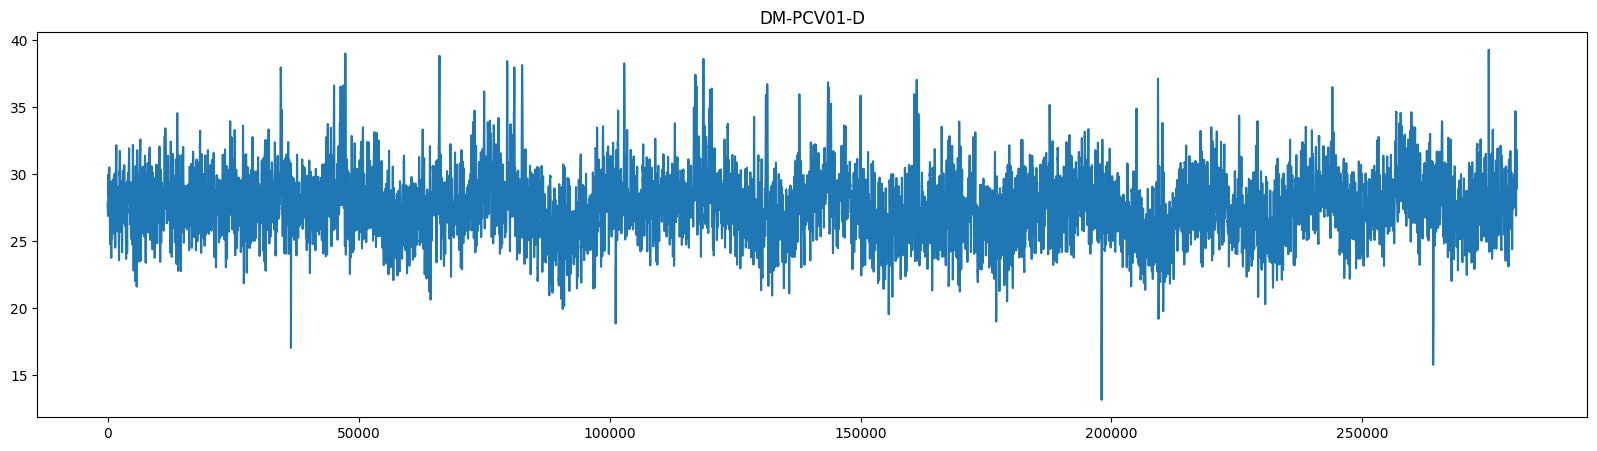

In [50]:
plot_time_series(data, "DM-PCV01-D")

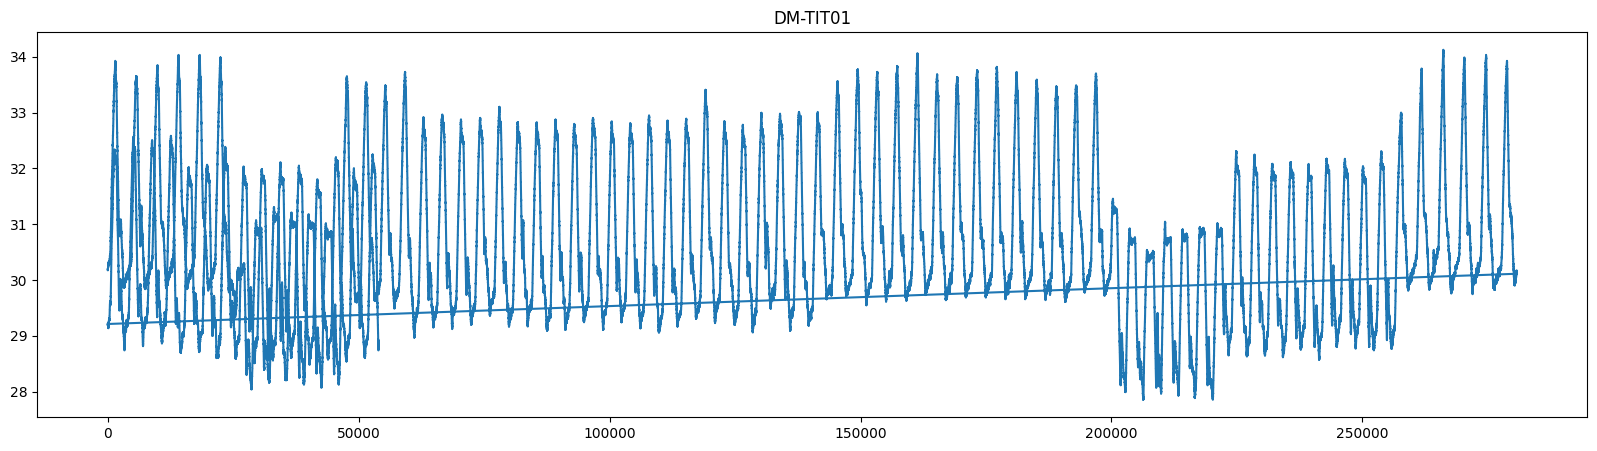

In [83]:
plot_time_series(data, "DM-TIT01")

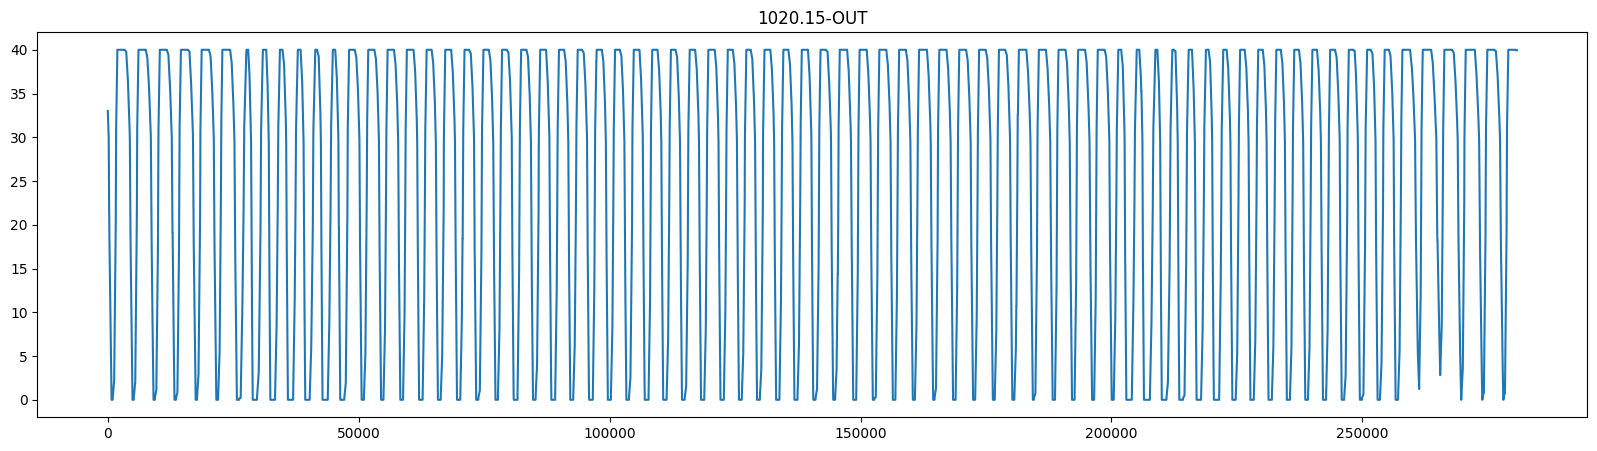

In [51]:
plot_time_series(data, "1020.15-OUT")

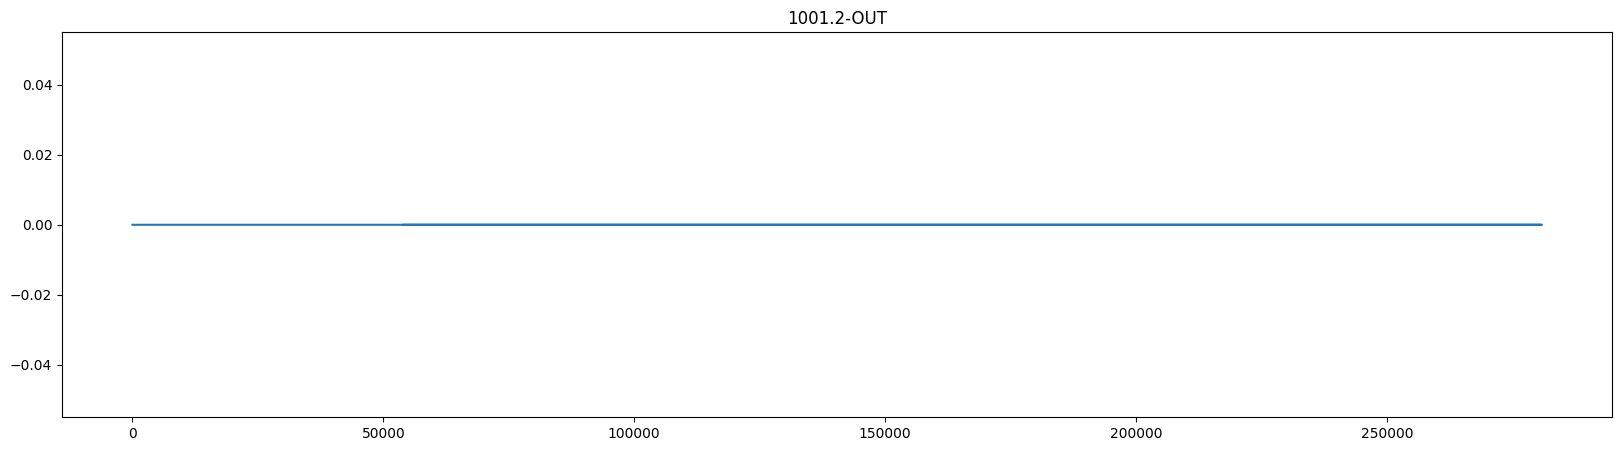

In [12]:
plot_time_series(data,"1001.2-OUT")

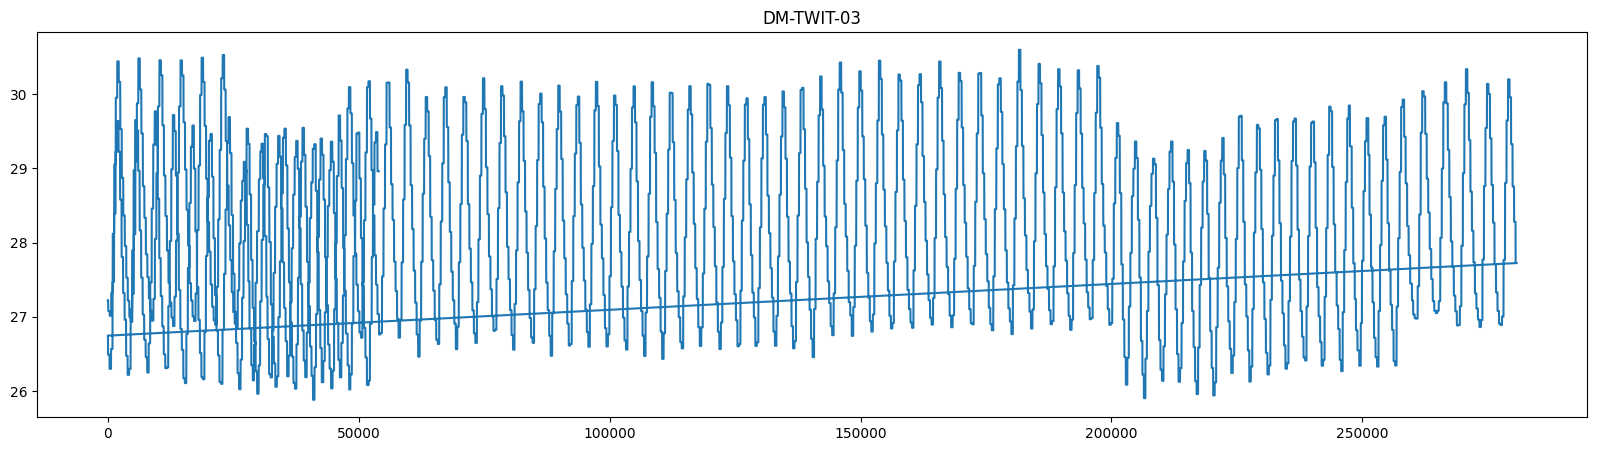

In [13]:
plot_time_series(data, "DM-TWIT-03")

### Distributions

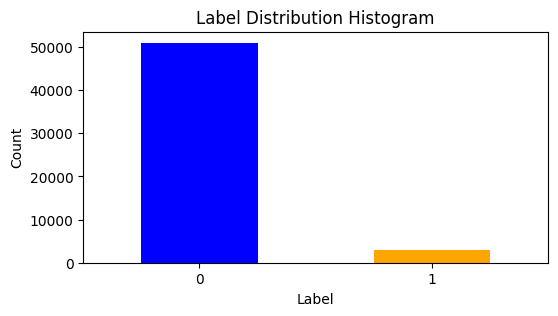

In [92]:
# Plot a histogram of the 'label' column
plt.figure(figsize=(6, 3))
label1['label'].value_counts().sort_index().plot(kind='bar', color=['blue', 'orange'])
plt.title('Label Distribution Histogram')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [109]:
label1[(label1['label'] == 1) & (label1['label'].shift() == 0)]

,timestamp,label
1503,2022-08-12 16:25:04,1
5700,2022-08-12 17:35:01,1
9136,2022-08-12 18:32:17,1
12063,2022-08-12 19:21:04,1
16980,2022-08-12 20:43:01,1
20160,2022-08-12 21:36:01,1
24420,2022-08-12 22:47:01,1
27314,2022-08-12 23:35:15,1
30303,2022-08-13 00:25:04,1
34448,2022-08-13 01:34:09,1


In [135]:
label1[(label1['label'] == 0) & (label1['label'].shift() == 1)]

,timestamp,label
1741,2022-08-12 16:29:02,0
5899,2022-08-12 17:38:20,0
9293,2022-08-12 18:34:54,0
12228,2022-08-12 19:23:49,0
17142,2022-08-12 20:45:43,0
20358,2022-08-12 21:39:19,0
25025,2022-08-12 22:57:06,0
27411,2022-08-12 23:36:52,0
30434,2022-08-13 00:27:15,0
34504,2022-08-13 01:35:05,0


In [130]:
data[data['Timestamp'] =='2022-08-13 00:25:04']

,Timestamp,DM-PP01-R,DM-FT01Z,DM-FT02Z,DM-FT03Z,1001.2-OUT,1001.7-OUT1,1001.7-OUT2,1001.8-OUT,1002.2-OUT,...,DM-PCV01-D,DM-PCV01-Z,DM-PCV02-D,DM-PCV02-Z,DM-PIT01,DM-PIT02,DM-PWIT-03,DM-TIT01,DM-TIT02,DM-TWIT-03
1504,2022-08-12 16:25:04,0,277.271271,29.991373,976.592957,0,0,0,0,0,...,22.450037,22.477722,12.0,11.682127,0.857696,0.370941,0.000715,32.186886,38.442986,28.390686


In [138]:
changes_df = data.iloc[1450: 1850]

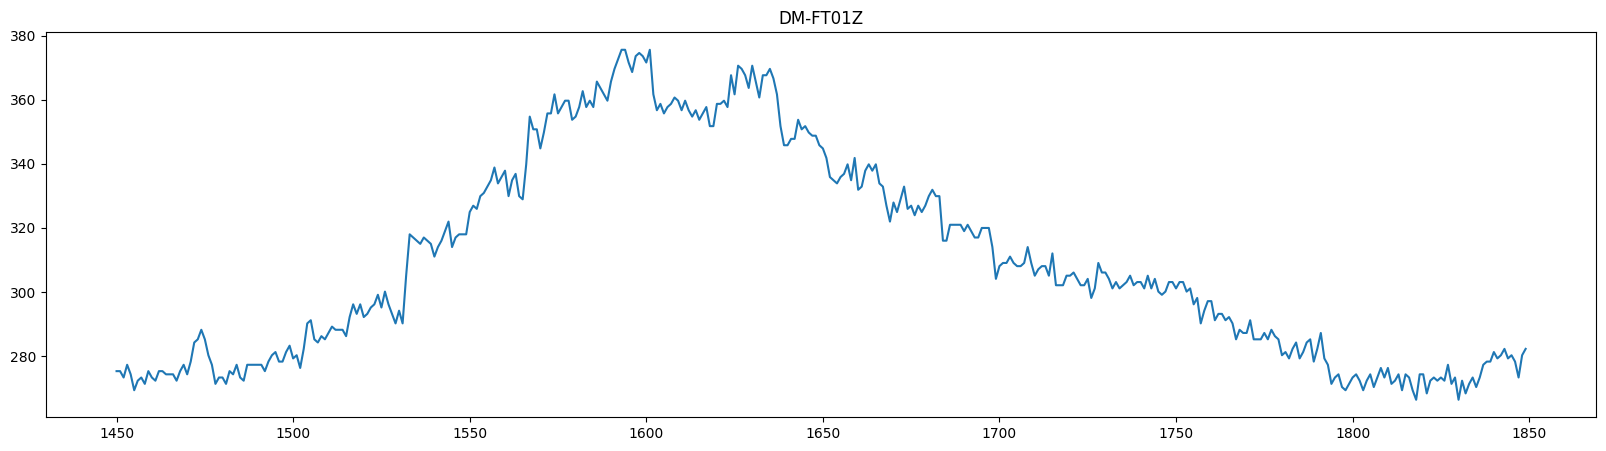

In [158]:
plot_time_series(changes_df, "DM-FT01Z")

/var/folders/07/b_mqfzkn0fzbvjz9y6nbfyf40000gn/T/ipykernel_35695/4232700415.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_hourly = sampling.groupby(sampling['Timestamp'].dt.hour).mean().reset_index()


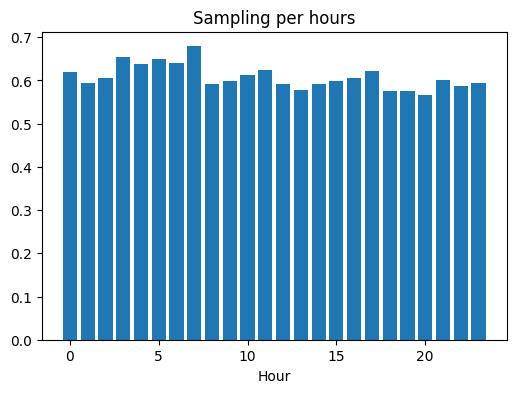

In [161]:
# Convert 'timestamp' to datetime format (if not already)
sampling = data.copy()
sampling['Timestamp'] = pd.to_datetime(sampling['Timestamp'])

# Resample for the specific day with hourly frequency
df_hourly = sampling.groupby(sampling['Timestamp'].dt.hour).mean().reset_index()

# Plot the result
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(df_hourly.index, df_hourly['DM-PIT02'], width=0.8, align='center')
plt.title('Sampling per hours')
plt.xlabel('Hour')
plt.show()